In [1]:
options(warn = -1)
suppressMessages({
    library(Seurat)
    library(tidyverse)
    library(clusterProfiler)
    library(org.Mm.eg.db)
})
options(warn = 1)

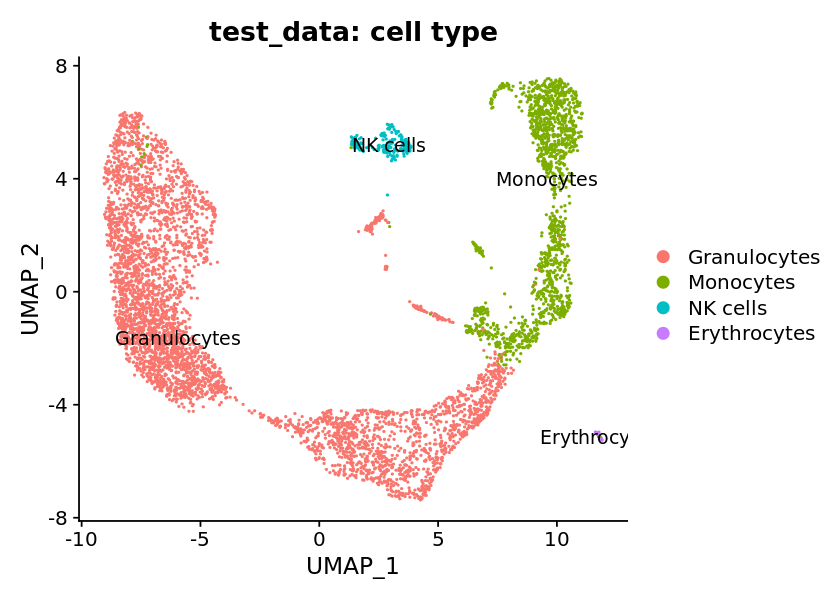

In [2]:
# Load rds (seurat object with cell annotations)
data_seurat <- readRDS("../data/test.rds")
sample_name <- unique(data_seurat$sample)
options(repr.plot.height=5 , repr.plot.width=7)
DimPlot(data_seurat, group.by = "cluster", label = T) +
    ggtitle(paste0(sample_name, ": cell type"))

# Load sweet tag info
sweet_tag <- read.table("../data/test/04.count_tag/test_tsne_tag.tsv", sep="\t", header = T, row.names = 1)
sweet_tag$barcode <- paste0(sample_name, "_", row.names(sweet_tag))
row.names(sweet_tag) <- sweet_tag$barcode
sweet_tag <- sweet_tag[colnames(data_seurat),]
data_seurat$tag_UMI <- sweet_tag$sweet_tag

Warning message:
“Removed 4 rows containing non-finite values (`stat_ydensity()`).”


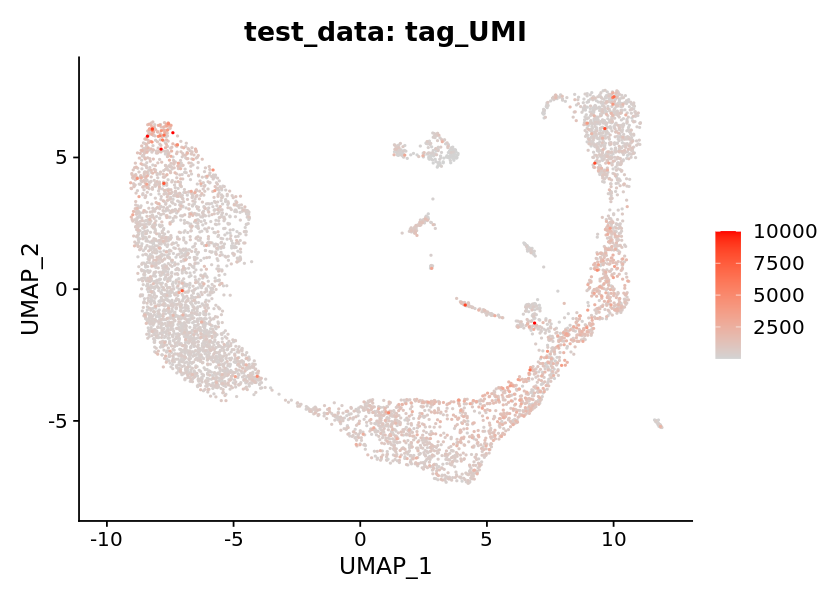

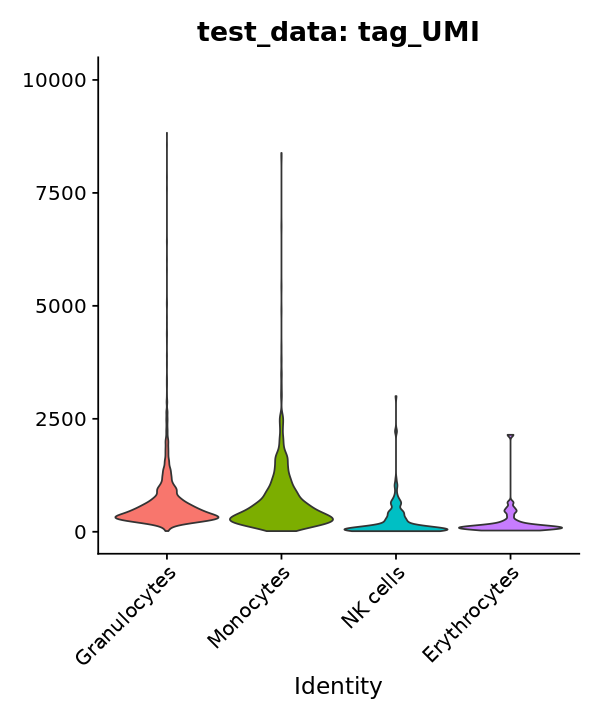

In [3]:
# Requirement 1： visualization of tags 
options(repr.plot.height=5 , repr.plot.width=7)
FeaturePlot(data_seurat, features ="tag_UMI", cols = c('lightgrey','#FF0000'), order = T, max.cutoff = 10000) +
    ggtitle(paste0(sample_name, ": tag_UMI"))

options(repr.plot.height=6 , repr.plot.width=5)
VlnPlot(data_seurat, features ='tag_UMI',group.by = "cluster", y.max = 10000, pt.size = 0) +
    NoLegend() +
    ggtitle(paste0(sample_name,": tag_UMI"))

[1] "analyis cluster: Monocytes"
[1] "cell number: 1506"
[1] "cell number of high group: 301"
[1] "cell number of low group: 301"


Warning message:
“Removed 2 rows containing non-finite values (`stat_ydensity()`).”


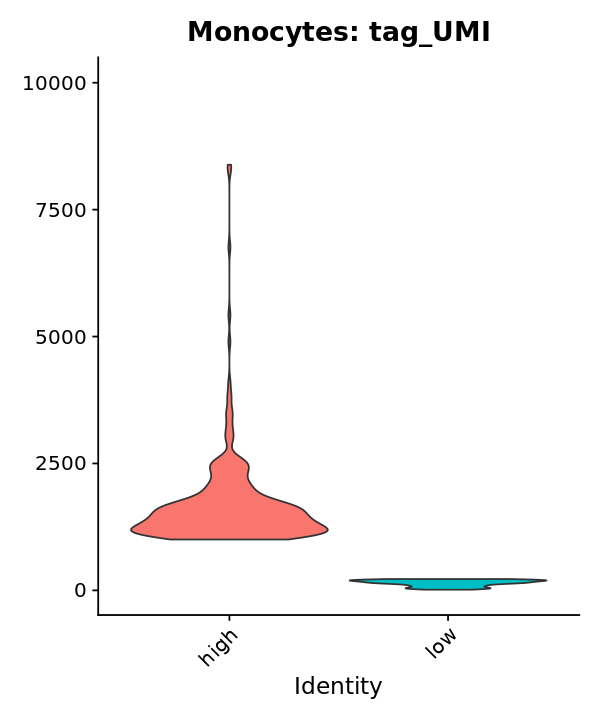

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for size is already present.
Adding another scale for size, which will replace the existing scale.


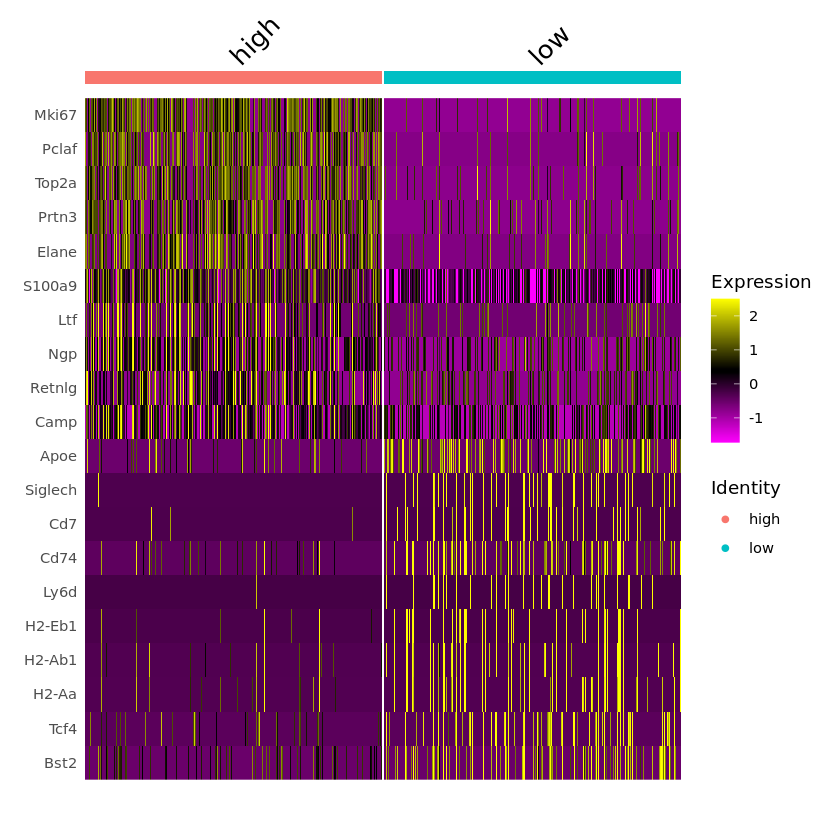

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for size is already present.
Adding another scale for size, which will replace the existing scale.


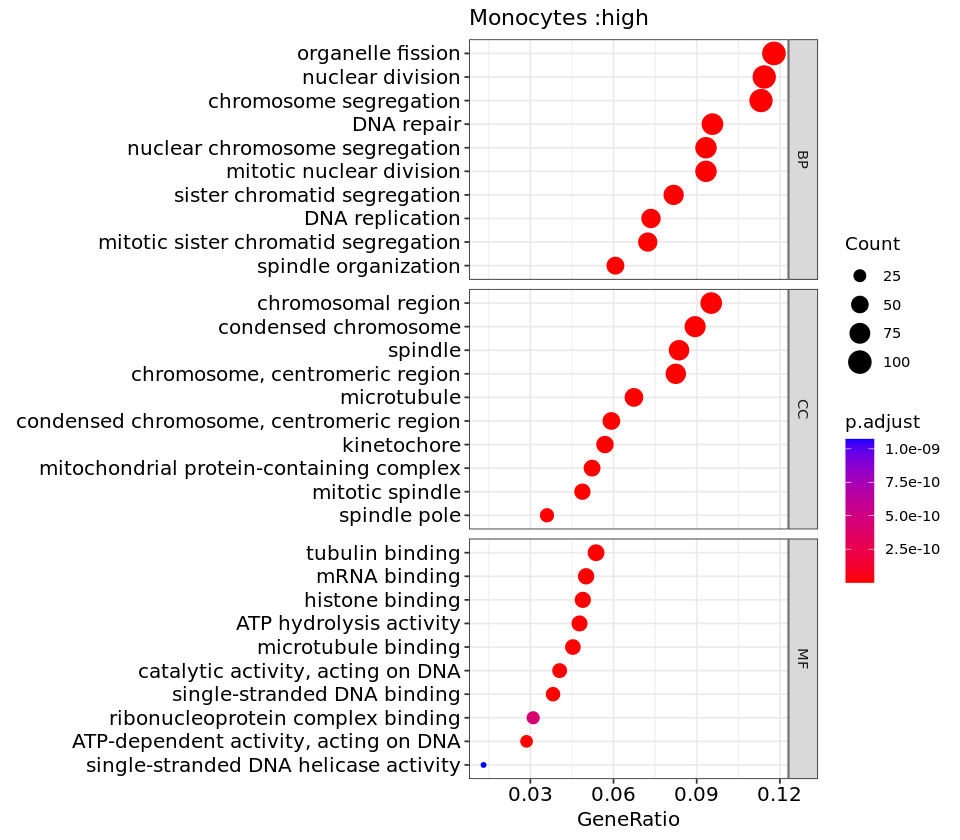

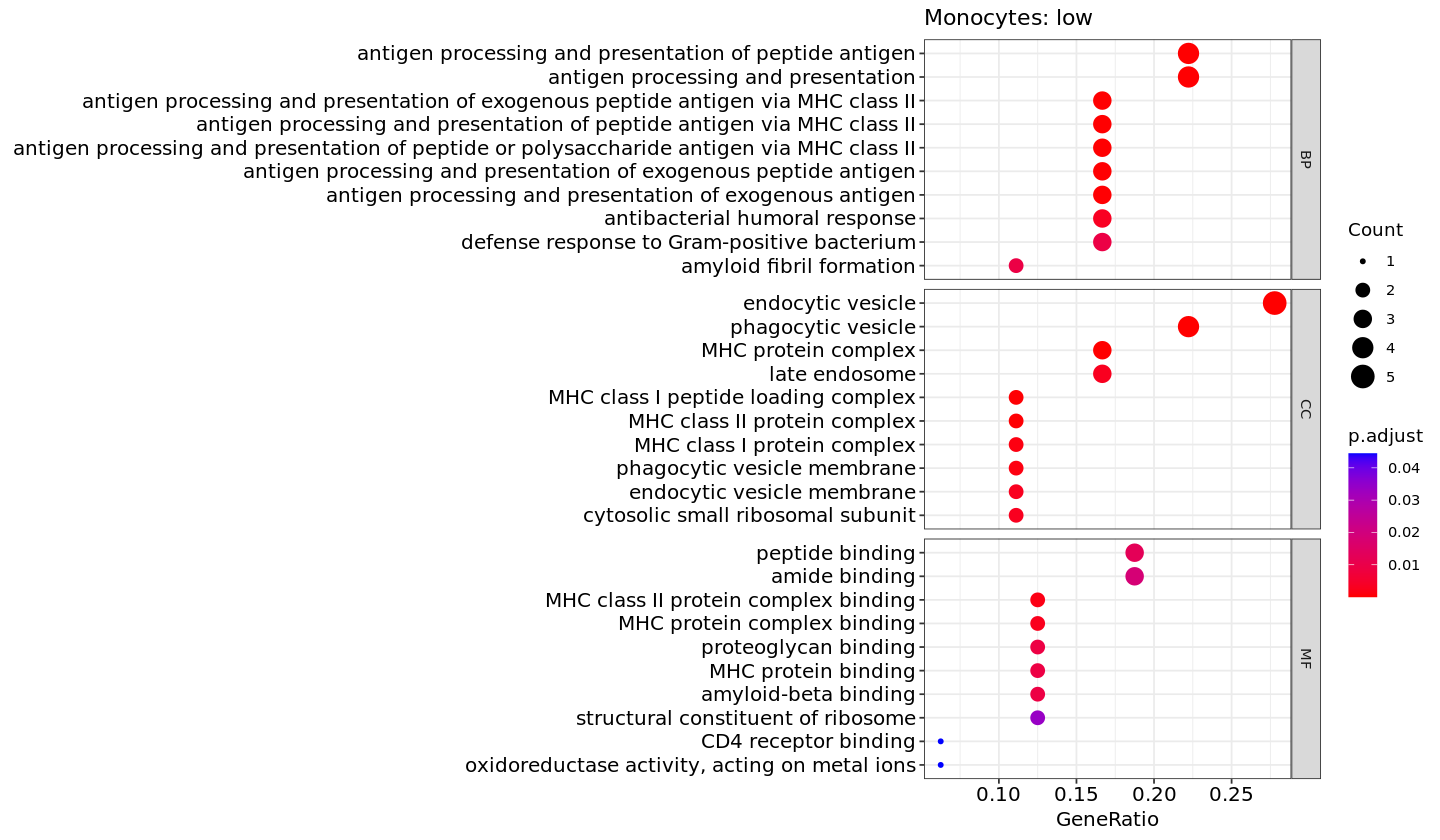

In [4]:
# Requirement 2： Comparison between high and low groups
# Take Monocytes as an axample
cluster_name <- "Monocytes" 
data_analysis <- subset(data_seurat, subset = cluster == cluster_name)
print(paste0("analyis cluster: ", cluster_name))
print(paste0("cell number: ", ncol(data_analysis)))
function_set_sweet_group <- function(data, percent){
    group <- colnames(data)
    high_barcode <- names(data$tag_UMI[order(data$tag_UMI, decreasing = T)][1:floor(ncol(data)*percent)])
    group[ group %in% high_barcode] = "high"
    low_barcode <- names(data$tag_UMI[order(data$tag_UMI)][1:floor(ncol(data)*percent)])
    group[ group %in% low_barcode] = "low"
    group[ !group %in% c("high","low")] = "medium"
    return(group)
}
data_analysis$tag_UMI_group <- function_set_sweet_group(data_analysis, percent = 0.2)
data_analysis <- subset(data_analysis, subset = tag_UMI_group != "medium")
data_analysis$tag_UMI_group <- factor(data_analysis$tag_UMI_group, levels = c('high','low'))
print(paste0("cell number of high group: ", sum(data_analysis$tag_UMI_group == 'high')))
print(paste0("cell number of low group: ", sum(data_analysis$tag_UMI_group == 'low')))

# tag between groups
options(repr.plot.height=6 , repr.plot.width=5)
VlnPlot(data_analysis, features ='tag_UMI',group.by = "tag_UMI_group", y.max = 10000, pt.size = 0) +
    NoLegend() +
    ggtitle(paste0(cluster_name,": tag_UMI"))


# FindMarkers
Idents(data_analysis) <- data_analysis$tag_UMI_group
markers_df <- FindAllMarkers(data_analysis, only.pos = T, verbose = F)
markers_high = markers_df$gene[ markers_df$cluster=='high' & markers_df$p_val_adj < 0.05 ]
markers_low = markers_df$gene[ markers_df$cluster=='low' & markers_df$p_val_adj < 0.05 ]

# heatmap
data_plot <- ScaleData(data_analysis, features = row.names(data_analysis@assays$RNA@data), verbose = F) 
options(repr.plot.height=7 , repr.plot.width=7)
DoHeatmap(object = data_plot, 
          features = c(markers_df %>% filter(cluster == "high") %>% top_n(n = 10, wt = avg_log2FC) %>% dplyr::select(gene) %>% unlist() %>% as.character(), 
                       markers_df %>% filter(cluster == "low") %>% top_n(n = 10, wt = avg_log2FC) %>% dplyr::select(gene) %>% unlist() %>% as.character()))

# GO enrichment
go_high <- enrichGO(gene = markers_high, OrgDb = "org.Mm.eg.db", keyType  = 'SYMBOL', ont="all")
go_low <- enrichGO(gene = markers_low, OrgDb = "org.Mm.eg.db", keyType  = 'SYMBOL', ont="all")

options(repr.plot.height=7 , repr.plot.width=8)
dotplot(go_high, split="ONTOLOGY") +
    facet_grid(ONTOLOGY~., scale="free") +
    ggtitle(paste0(cluster_name, " :high")) +
    scale_y_discrete(labels = function(x) {str_wrap(x, width = 90)})+
    scale_size()

options(repr.plot.height=7 , repr.plot.width=12)
dotplot(go_low, split="ONTOLOGY") +
    facet_grid(ONTOLOGY~., scale="free") + 
    ggtitle(paste0(cluster_name, ": low")) +
    scale_y_discrete(labels = function(x) {str_wrap(x, width = 90)})+
    scale_size()